In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineCosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x: torch.Tensor, t):
        return self.mlp(x)

In [4]:
dataset = SineCosineDataset(type="sine", num_points=64)
dataloader = DataLoader(dataset, collate_fn=dataset.collate, batch_size=128)

In [5]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=1000, learn_sigma=False)
# dit = UnconditionalPointCloudDiT(input_size=32, in_channels=2, depth=1, num_heads=1, hidden_size=128)
dit = MLP().to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [6]:
count_parameters(dit)

198658

In [7]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=10000 * 2,
    lr=1e-2
)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:53<00:00, 371.23it/s, loss=0.39] 


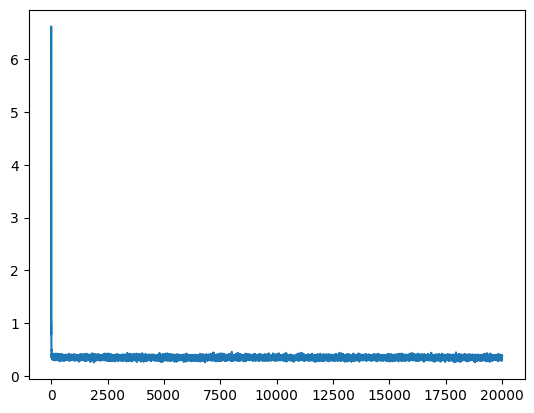

In [8]:
losses = trainer.train()
plt.plot(losses)

Sampling:  26%|██▋       | 263/1000 [00:00<00:00, 2625.80it/s]

Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2627.18it/s]


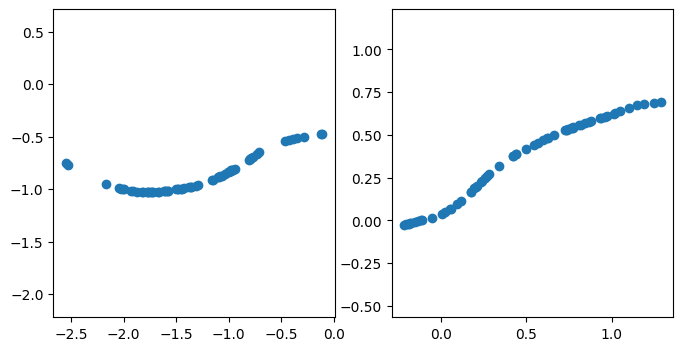

In [16]:
sample = diffusion.p_sample_loop(dit, (2, 64, 2), clip_denoised=False)
plot_point_clouds(sample, 1, 2)